# Overview

This week is about tying everything together. We try to combine our work on networks plus our work on language in order to understand and analyze human behavior. We'll be working on a cool dataset of humans playing a game on (a special version of) wikipedia called "wikispeedia" (the game is now defunct and wikispeedia.org is a page about GPS coordinates of speed-traps, so you can't play it). 

Here's how the game worked:

> In the game, users are asked to navigate from a given _source_ article (e.g. https://en.wikipedia.org/wiki/Gold_dollar) to a given _target_ article (e.g. https://en.wikipedia.org/wiki/Ronald_Reagan), **by only clicking Wikipedia links**. A condensed version of Wikipedia (4,604 articles) is used. 

So this dataset contains **human navigation paths** (clicking from page to page to find a target) and today we will work on this dataset to see if we can use our skills to understand how human navigation works. We will think about the following questions.

* Path lengths
* Betweenness from the human perspective
* What characterizes human paths?

Since we're putting our existing skills to use, there is very little reading today - it's all about exploring the dataset. Let's get started.

## Download the dataset

The first thing we're going to do is download the dataset. Today everything related to data is nice, clean, and easy to work with (Yay). You can get the dataset [here](https://snap.stanford.edu/data/wikispeedia.html). You will need to get 

* The list of wiki articles
* The network connections
* The navigation paths
* Plaintext of the wiki articles

In [57]:
import cStringIO
from collections import Counter
from __future__ import division
from matplotlib import pyplot as plt
import networkx as nx
from networkx import NetworkXNoPath
import numpy as np
import os
import pandas as pd
import pprint
import scipy.stats as stats
import tarfile
import urllib

# IPython specifics
%matplotlib inline

directory = 'wikispeedia'
if not os.path.exists(directory):
    os.makedirs(directory)
text_file = 'texts.tar.gz'
network_file = 'network.tar.gz'

## Fetch data and buil network

In [2]:
# get archives and save to disk
urllib.urlretrieve('https://snap.stanford.edu/data/wikispeedia/wikispeedia_paths-and-graph.tar.gz', 
                   '{0}/{1}'.format(directory, text_file))
urllib.urlretrieve('https://snap.stanford.edu/data/wikispeedia/wikispeedia_articles_plaintext.tar.gz', 
                   '{0}/{1}'.format(directory, network_file))

('wikispeedia/network.tar.gz',
 <httplib.HTTPMessage instance at 0x7f5558c72440>)

In [3]:
# extract archives
tar_t = tarfile.open('{0}/{1}'.format(directory, text_file))
tar_t.extractall(directory)
tar_t.close()
tar_p = tarfile.open('{0}/{1}'.format(directory, network_file))
tar_p.extractall(directory)
tar_p.close()

In [4]:
# file location articles
net_dir = 'wikispeedia_paths-and-graph'
articles = '{0}/{1}/articles.tsv'.format(directory, net_dir)

# dataframe of wiki articles, skip initial header rows
wiki_articles = pd.read_csv(articles, sep='\t', names=['article'], skiprows=xrange(0, 12))
print wiki_articles.head()

                            article
0  %C3%81ed%C3%A1n_mac_Gabr%C3%A1in
1                        %C3%85land
2                %C3%89douard_Manet
3                         %C3%89ire
4        %C3%93engus_I_of_the_Picts


In [5]:
# create one node per article
w_graph = nx.DiGraph()
w_graph.add_nodes_from(wiki_articles['article'].tolist()) 

In [6]:
# file location links
links = '{0}/{1}/links.tsv'.format(directory, net_dir)

# dataframe of network connections, skip initial header rows
wiki_links = pd.read_csv(links, sep='\t', names=['linkSource', 'linkTarget'], skiprows=xrange(0, 12))
print wiki_links.head()

                         linkSource      linkTarget
0  %C3%81ed%C3%A1n_mac_Gabr%C3%A1in            Bede
1  %C3%81ed%C3%A1n_mac_Gabr%C3%A1in         Columba
2  %C3%81ed%C3%A1n_mac_Gabr%C3%A1in  D%C3%A1l_Riata
3  %C3%81ed%C3%A1n_mac_Gabr%C3%A1in   Great_Britain
4  %C3%81ed%C3%A1n_mac_Gabr%C3%A1in         Ireland


In [7]:
# add as links to the network
link_list = list(zip(wiki_links['linkSource'], wiki_links['linkTarget']))

for l_pair in link_list:
    w_graph.add_edge(l_pair[0], l_pair[1])

In [8]:
# file location paths
paths = '{0}/{1}/paths_finished.tsv'.format(directory, net_dir)

# dataframe of navigation paths, skip initial header rows
header = ['hashedIpAddress', 'timestamp', 'durationInSec', 'path', 'rating']
human_paths = pd.read_csv(paths, sep='\t', names=header, skiprows=xrange(0, 16))
print human_paths.head()

    hashedIpAddress   timestamp  durationInSec  \
0  6a3701d319fc3754  1297740409            166   
1  3824310e536af032  1344753412             88   
2  415612e93584d30e  1349298640            138   
3  64dd5cd342e3780c  1265613925             37   
4  015245d773376aab  1366730828            175   

                                                path  rating  
0  14th_century;15th_century;16th_century;Pacific...     NaN  
1  14th_century;Europe;Africa;Atlantic_slave_trad...     3.0  
2  14th_century;Niger;Nigeria;British_Empire;Slav...     NaN  
3     14th_century;Renaissance;Ancient_Greece;Greece     NaN  
4  14th_century;Italy;Roman_Catholic_Church;HIV;R...     3.0  


In [9]:
#wiki_plaintext

# Path lengths

The first thing we want to take a look at is path lengths. NetworkX allows us to calculate the shortest path between any pair of articles. We begin by comparing the length of human and shortests paths. 

_Exercises_
> * For each _source_/_target_ pair in the list of human navigation paths, calculate the shortest path using NetworkX. Plot the distribution of path lengths. Mine looks something like this:
![alt text](https://raw.githubusercontent.com/suneman/socialgraphs2016/master/files/shortest-path.png)

In [150]:
# create set of source and target pairs
path_list = human_paths['path'].tolist()

p_compare = dict()
for path in path_list:
    # list of each node visited
    n = path.split(';')
    # elimate back choice as a visited node
    nodes_visited = [x for x in n if x != '<']
    # first element source, last target
    source = nodes_visited[0]
    target = nodes_visited[-1]
    length = len(nodes_visited)
    # add to dict with key: tuple source, target and value: list of lengths
    if (source, target) not in p_compare:
        p_compare[(source, target)] = {
            'human_shortest_path': [length],
            'human_shortest_nodes': nodes_visited
        };
    else:
        key = (source, target)
        current_val = p_compare[key]['human_shortest_path']
        # extend the list with lengths
        p_compare[key]['human_shortest_path'] = current_val + [length]
        # save eventually new shortest path nodes
        if len(p_compare[key]['human_shortest_nodes']) < length:
            p_compare[key]['human_shortest_nodes'] = nodes_visited

# show small excerpt of 14th_century (first in human_paths)
for p in p_compare:
    if p[0] == '14th_century':
        print p, p_compare[p], "\n"

('14th_century', 'John_F._Kennedy') {'human_shortest_path': [7, 6], 'human_shortest_nodes': ['14th_century', 'Italy', 'Roman_Catholic_Church', 'HIV', 'Ronald_Reagan', 'President_of_the_United_States', 'John_F._Kennedy']} 

('14th_century', 'Rainbow') {'human_shortest_path': [6, 4, 7, 12, 10, 5, 12, 7, 5, 10, 10, 8, 11, 8, 7, 4, 4, 5, 10, 4, 7, 4, 4, 5, 5, 8, 4], 'human_shortest_nodes': ['14th_century', 'Time', 'Science', 'Nature', 'Weather', 'Sunlight', 'Sun', 'Earth%27s_atmosphere', 'Ultraviolet', 'Color', 'Light', 'Rainbow']} 

('14th_century', 'Elizabeth_I_of_England') {'human_shortest_path': [15, 4, 6, 6, 4], 'human_shortest_nodes': ['14th_century', 'England', 'London', 'Spanish_Armada', 'England', 'Great_Britain', '10th_century', '11th_century', '12th_century', '13th_century', '14th_century', '15th_century', '16th_century', 'Francis_Drake', 'Elizabeth_I_of_England']} 

('14th_century', 'Sodium') {'human_shortest_path': [6, 6], 'human_shortest_nodes': ['14th_century', 'Ottoman_Empi

In [151]:
# for each pair calculate the shortest path
for p in p_compare.keys():
    try:
        sp = nx.shortest_path(w_graph, source=p[0], target=p[1])
        p_compare[p]['nx_shortest_path'] = len(sp)
        p_compare[p]['nx_shortest_nodes'] = sp
    except NetworkXNoPath:
        print 'The path from \'{0}\' to \'{1}\' does not exist in file \'{2}\' only in \'{3}\'\n'.format(
            p[0], p[1], links, paths)
        del p_compare[p]
    
# show small excerpt of 14th_century
for p in p_compare:
    if p[0] == '14th_century':
        print p, p_compare[p], "\n"

The path from 'Bird' to 'Wikipedia_Text_of_the_GNU_Free_Documentation_License' does not exist in file 'wikispeedia/wikispeedia_paths-and-graph/links.tsv' only in 'wikispeedia/wikispeedia_paths-and-graph/paths_finished.tsv'

('14th_century', 'John_F._Kennedy') {'nx_shortest_nodes': ['14th_century', 'Italy', 'United_States', 'John_F._Kennedy'], 'human_shortest_path': [7, 6], 'human_shortest_nodes': ['14th_century', 'Italy', 'Roman_Catholic_Church', 'HIV', 'Ronald_Reagan', 'President_of_the_United_States', 'John_F._Kennedy'], 'nx_shortest_path': 4} 

('14th_century', 'Rainbow') {'nx_shortest_nodes': ['14th_century', '15th_century', 'Wars_of_the_Roses', 'Rainbow'], 'human_shortest_path': [6, 4, 7, 12, 10, 5, 12, 7, 5, 10, 10, 8, 11, 8, 7, 4, 4, 5, 10, 4, 7, 4, 4, 5, 5, 8, 4], 'human_shortest_nodes': ['14th_century', 'Time', 'Science', 'Nature', 'Weather', 'Sunlight', 'Sun', 'Earth%27s_atmosphere', 'Ultraviolet', 'Color', 'Light', 'Rainbow'], 'nx_shortest_path': 4} 

('14th_century', 'Eliza

In [295]:
dat_nx = list()
for p in p_compare:
    dat_nx.append(p_compare[p]['nx_shortest_path'])

In [318]:
def plot_distr_path(dat, _type):
    # distribution in numbers
    num_of_paths = Counter(dat)
    print 'Counted shortest path lengths', num_of_paths

    # init plot labels
    fig = plt.figure(num=None, figsize=(14, 10), dpi=80, facecolor='w', edgecolor='k')
    fig.suptitle('', fontsize=28)

    if _type == 'hist':
        # distribution as line graph
        plt.subplot(2, 2, (1, 2))
        line = plt.plot(num_of_paths.keys(), num_of_paths.values(), label='shortest path')
        plt.legend(handles=line)
        plt.title('Distribution of path lengths (nx graph)')
        plt.ylabel('number of paths')
        plt.xlabel('path length')
    if _type == 'loglog':
        # distribution as loglog graph
        plt.subplot(2, 2, (1, 2))
        line = plt.loglog(num_of_paths.keys(), num_of_paths.values(), label='shortest path')
        plt.legend(handles=line)
        plt.title('Distribution of path lengths (human)')
        plt.ylabel('number of paths')
        plt.xlabel('path length')
    
    # distributon as histogram
    plt.subplot(2, 2, 3)
    plt.hist(dat, bins=len(num_of_paths))
    plt.title('Distribution as histogram')
    plt.ylabel('number of paths')
    plt.xlabel('path length')

    # normed in one, with fixed bin size
    plt.subplot(2, 2, 4)
    dat = sorted(dat)
    fit = stats.norm.pdf(dat, np.mean(dat), np.std(dat))
    plt.title('Distribution as normed histogram with bin size 10')
    line = plt.plot(dat, fit, '-o', label='shortest path')
    plt.hist(dat, bins=10, normed=True)
    plt.ylabel('number of paths')
    plt.xlabel('path length (normed)')
    
    # display
    plt.tight_layout()
    plt.show()

Counted shortest path lengths Counter({4: 15310, 3: 8327, 5: 3955, 2: 816, 6: 278, 7: 20, 1: 11})


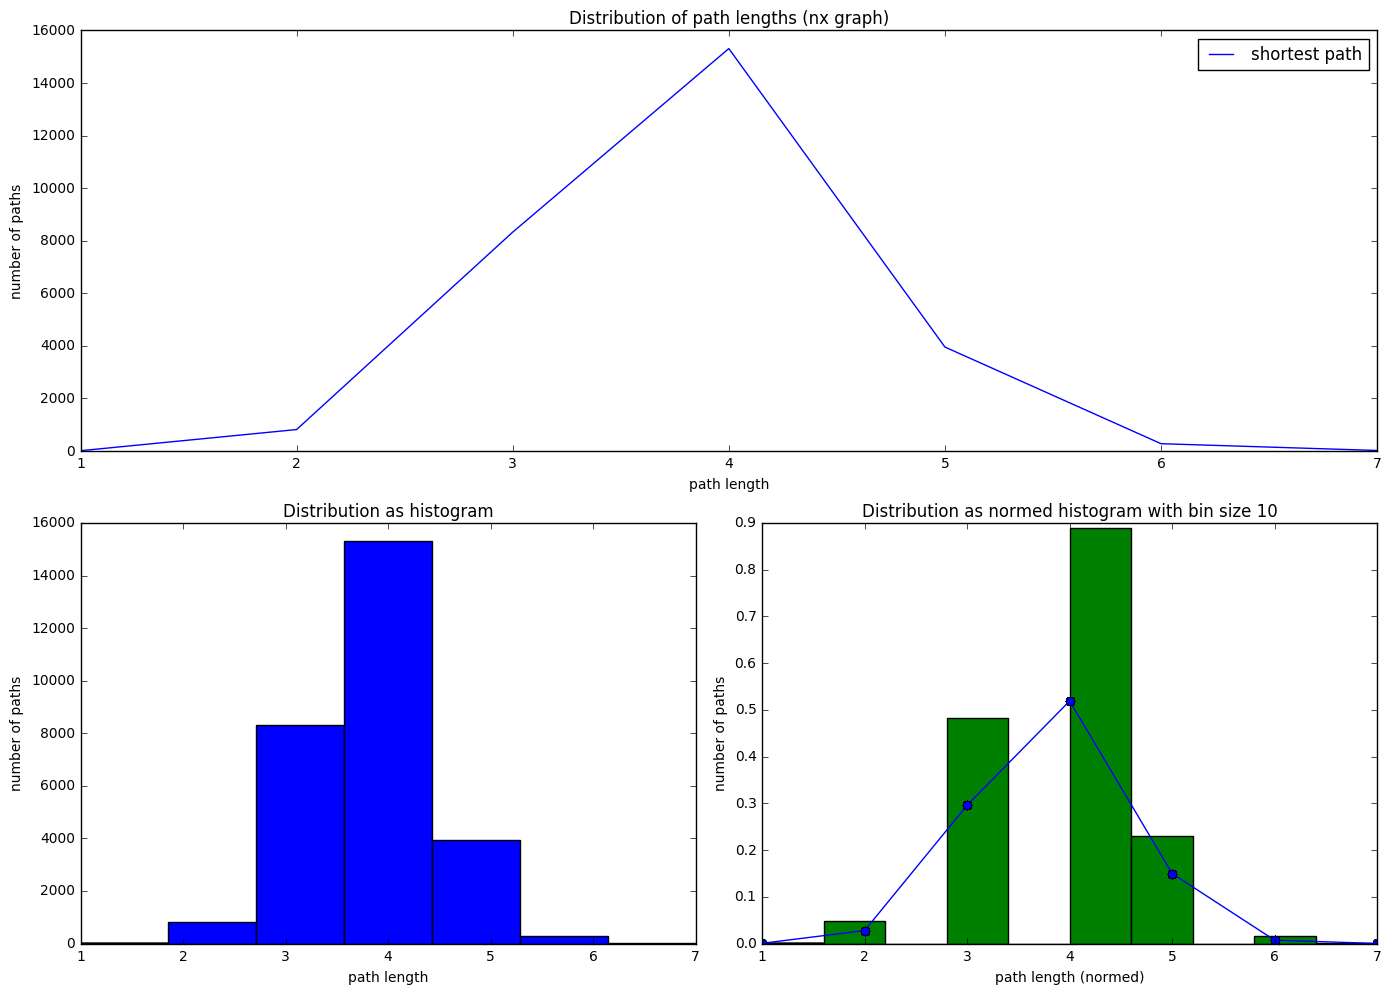

In [319]:
plot_distr_path(dat_nx, 'hist')

The differences to the teachers plot could come from the difference of using a directed or an undirected graph (directed graph has longer shortest paths). Another reason can also be keeping duplicates from `paths_finished.tsv` instead of looking at each node/link pair unique like above. Lastly the bin sizes can be different 

> * For each _source_/_target_ pair, calculate the length of the human path. The dataset contains information on people who regret a navigation step and hit the "back" button in their web-browser. It's up to you how to incorporate that information in the path. Justify your choice. Plot the distribution of human path lengths. If I ignore back steps, I get this on log-log scale:
![alt text](https://raw.githubusercontent.com/suneman/socialgraphs2016/master/files/human-path.png)

Counted shortest path lengths Counter({5.0: 5789, 4.0: 5481, 6.0: 5081, 7.0: 3565, 3.0: 2406, 8.0: 2183, 9.0: 1342, 10.0: 772, 2.0: 516, 11.0: 492, 12.0: 262, 13.0: 202, 14.0: 151, 15.0: 112, 16.0: 72, 17.0: 54, 18.0: 43, 19.0: 33, 20.0: 27, 23.0: 20, 21.0: 16, 22.0: 15, 25.0: 14, 1.0: 11, 24.0: 10, 26.0: 5, 28.0: 5, 31.0: 5, 27.0: 4, 29.0: 4, 33.0: 4, 38.0: 3, 30.0: 2, 32.0: 2, 35.0: 2, 36.0: 2, 40.0: 2, 37.0: 1, 42.0: 1, 43.0: 1, 45.0: 1, 46.0: 1, 54.0: 1, 55.0: 1, 91.0: 1})


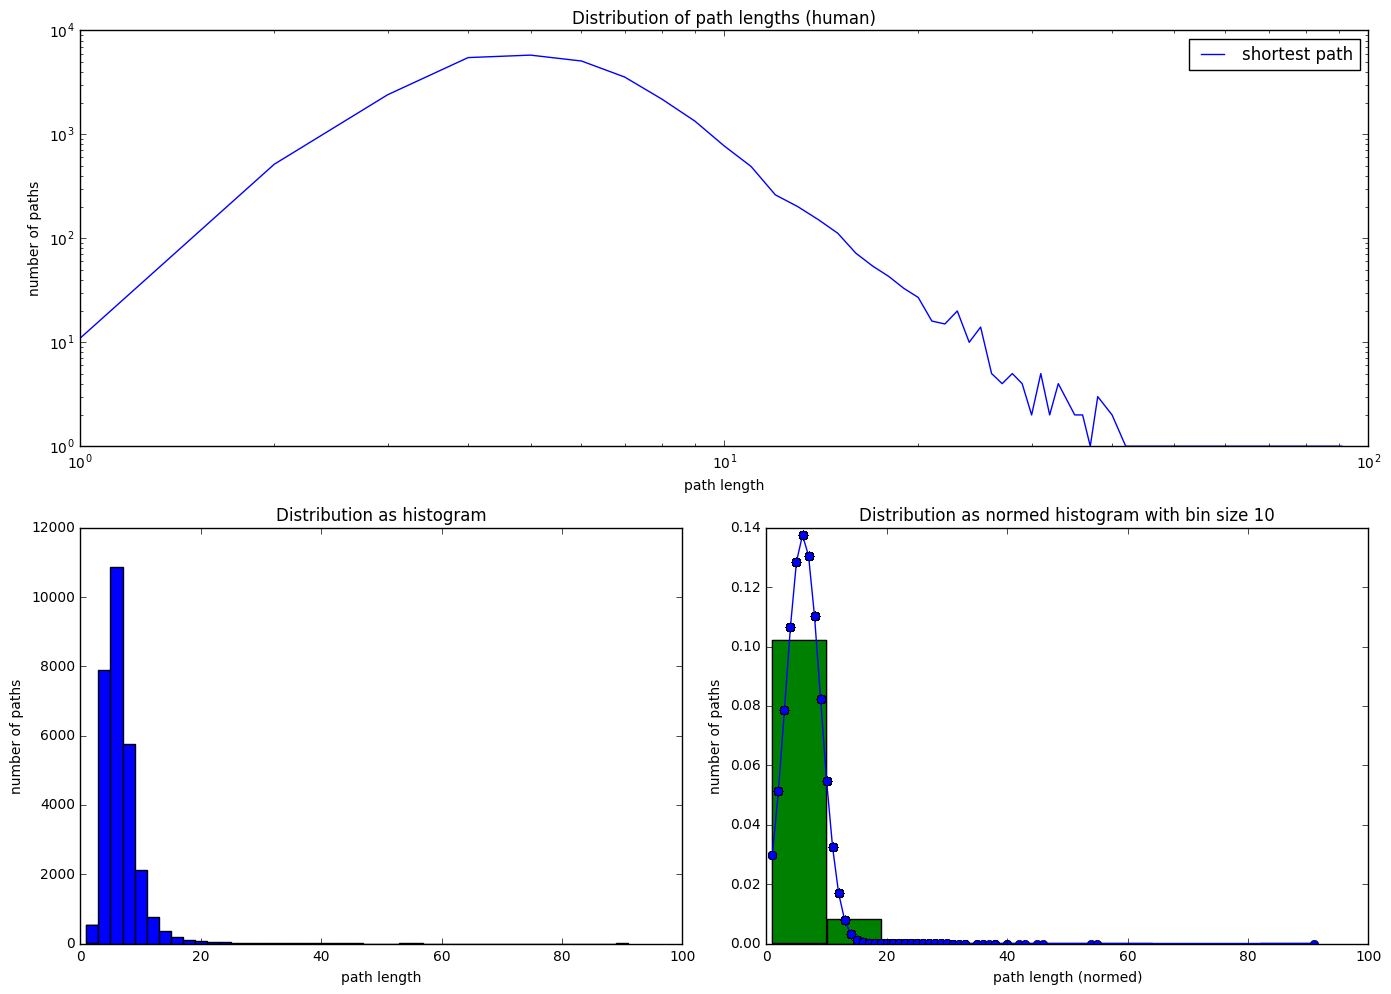

In [320]:
dat_human = list()
for p in p_compare:
    sh_p_list = p_compare[p]['human_shortest_path']
    # take the average to have one value
    avg = sum(sh_p_list) / len(sh_p_list)
    # values are rounded to reduce bin size
    dat_human.append(round(avg))
    
plot_distr_path(dat_human, 'loglog')

I did not incorporate the back button as a visited node because it is not represented as a node in the graph either. Maybe it was even accidentally caused.

> * How much longer are the human paths on average?


In [170]:
avg_longer = list()
for p in p_compare:
    sh_p_human_list = p_compare[p]['human_shortest_path']
    human = sum(sh_p_human_list) / len(sh_p_human_list)
    nx_graph = p_compare[p]['nx_shortest_path']
    
    # how much longer - value does not need to be rounded like in graph
    val = human - nx_graph
    # can only get 0 since nx_graph definetly has the shortest path
    avg_longer.append(val)
    
# display average
print "Human paths are on average", sum(avg_longer) / len(avg_longer), "clicks longer than the actual shortest path."

Human paths are on average 2.2065297235 clicks longer than the actual shortest path.


> * Create scatter plot where each point is a _source_/_target_ pair, and you have human path lengths on the $x$-axis and shortests paths on the $y$-axis.

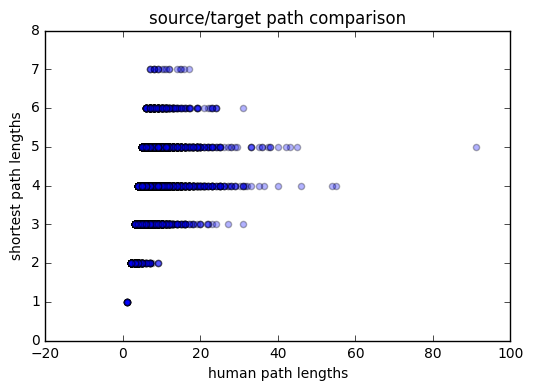

In [177]:
# add data
x, y = list(), list()
for p in p_compare:
    sh_p_human_list = p_compare[p]['human_shortest_path']
    x.append(sum(sh_p_human_list) / len(sh_p_human_list))
    
    y.append(p_compare[p]['nx_shortest_path'])

# draw plot
plt.scatter(x, y, alpha=0.3)
plt.title('source/target path comparison')
plt.xlabel('human path lengths')
plt.ylabel('shortest path lengths')
plt.show()

> * Is there a correlation between human/shortest path-lengths? What is the correlation.

When the link is on the same page (length 1) it is mostly found by humans. Also for 2 links in between pages (nodes) they are fairly close together until the spread becomes much greater for 3 to 7 links.

# Betweenness

An interesting definition of centrality is _betweenness centrality_ (here's a handy [link to the NetworkX documentation](http://networkx.readthedocs.io/en/stable/reference/generated/networkx.algorithms.centrality.betweenness_centrality.html)). In a traditional setting, this measure calculates all shortest paths in the network and then each node gets a score according to which fraction of all shortest paths pass through that node.


In this part, we will create our own version of centrality, based on the _source_/_target_ pairs in our dataset. We define a nodes's **navigation centrality** as follows. 

> *Navigation centrality* of node $i$ is the fraction of all naviagtion paths that pass through $i$. We exclude the source and target from the count. If a node has not been visited by a search, the navigation centrality of that node is defined to be zero.

In the exercises below, we investigate the relationship between navigation centrality and betweenness centrality.

*Exercises*

> Begin by calculating the betweenness centrality and navigation centrality of all nodes in the wikispedia dataset.
> Note that calculating the betweenness centrality can take quite a long time, so you might start it running in a separate notebook while first estimating it based on the existing human path.

In [180]:
b_cent_dict = nx.betweenness_centrality(w_graph)

In [267]:
def navigation_centrality(nodes, nav_paths):
    # how often is each node in the list
    cnt_nodes = Counter(nav_paths)
    
    # run through the list of nodes
    nav_cent = dict()
    for i in nodes:
        # define as zero
        nav_cent[i] = 0
        # number of times i is in naviagtion paths
        if cnt_nodes[i] != 0:
            # take fraction of all navigation paths
            nav_cent[i] = cnt_nodes[i] / len(nav_paths)
    return nav_cent

In [268]:
# create a list of all navigation paths
nav_paths = list()
for path in path_list:
    n = path.split(';')
    # exclude back links and first and last element
    nodes_path = [x for x in n[1:-1] if x != '<']
    # concatenate to main list
    nav_paths += nodes_path

nav_cent_dict = navigation_centrality(wiki_articles['article'].tolist(), nav_paths)

In [269]:
for key in sorted(b_cent_dict)[:15]:
    print key, b_cent_dict[key]

%C3%81ed%C3%A1n_mac_Gabr%C3%A1in 0.0
%C3%85land 0.0
%C3%89douard_Manet 0.0
%C3%89ire 0.0
%C3%93engus_I_of_the_Picts 0.0
%E2%82%AC2_commemorative_coins 0.0
10th_century 0.00052638082373
11th_century 0.000628076444177
12th_century 0.00133960639219
13th_century 0.000806657935376
14th_century 0.000506646882611
15th_Marine_Expeditionary_Unit 1.8950025078e-06
15th_century 0.00174924193608
16_Cygni 0.000216374656574
16_Cygni_Bb 4.60177284572e-06


In [270]:
for key in sorted(nav_cent_dict)[:15]:
    print key, nav_cent_dict[key]

%C3%81ed%C3%A1n_mac_Gabr%C3%A1in 0
%C3%85land 8.94486385917e-06
%C3%89douard_Manet 8.94486385917e-06
%C3%89ire 1.34172957888e-05
%C3%93engus_I_of_the_Picts 0
%E2%82%AC2_commemorative_coins 0
10th_century 0.000411463737522
11th_century 0.000420408601381
12th_century 0.000483022648395
13th_century 0.00043382589717
14th_century 0.000478550216466
15th_Marine_Expeditionary_Unit 0
15th_century 0.00064403019786
16_Cygni 0
16_Cygni_Bb 0


> * First, list the 5 pages with highest navigation centrality.

In [271]:
# sort dict after value and display element 0 to 4
print sorted(nav_cent_dict.items(), key=lambda t: t[1], reverse=True)[0:5]

[('United_States', 0.039464739346667145), ('Europe', 0.019316433503882072), ('United_Kingdom', 0.01726358724820208), ('Earth', 0.014101577873984758), ('England', 0.013967404916097177)]


> * Second, list the 5 pages with highest betweenness centrality.

In [272]:
# sort dict after value and display element 0 to 4
print sorted(b_cent_dict.items(), key=lambda t: t[1], reverse=True)[0:5]

[('United_States', 0.09360037318221956), ('United_Kingdom', 0.042163720769997685), ('England', 0.03223406679869201), ('Europe', 0.026851133195243022), ('Africa', 0.0240781266625001)]


> * Compare the two lists. Explain the differences between the two lists in your own words.

Betweenness centrality of a node $i$ is the sum of the fraction of all-pairs shortest paths that pass through $i$. On the contrary navigation centrality takes the human paths instead of the shortest paths. The more people go through one site to get to the target the higher the navigation centrality much like the betweenness centrality.

The main difference between the two dictionaries is that some people often go through a site where they think to find a link. Thus other wikipedia pages get a higher centrality compared to the actual flow that would be taken in the graph. Although the to entries are similar the values for navigation centrality are generally higher.

> * Create a scatterplot of betweenness centrality vs. navigation centrality.

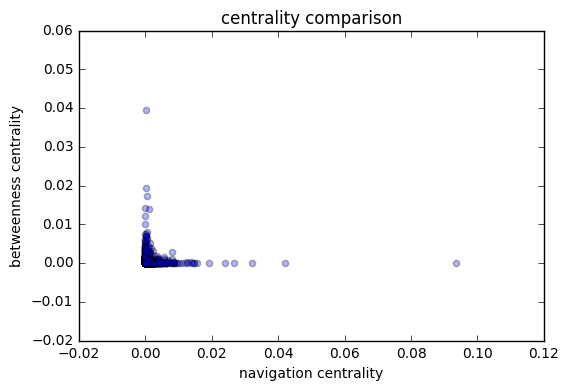

In [273]:
# add data betweenness centrality vs. navigation centrality
x = b_cent_dict.values()
y = nav_cent_dict.values()

# draw plot
plt.scatter(x, y, alpha=0.3)
plt.title('centrality comparison')
plt.xlabel('navigation centrality')
plt.ylabel('betweenness centrality')
plt.show()

> * Let's explore the pages that have navigation centrality equal to zero.
>   * How many pages have zero navigation centrality?

In [274]:
print "Number of pages with zero navigation centrality =", len([cent for cent in nav_cent_dict.values() if cent == 0])

Number of pages with zero navigation centrality = 1198


>   * What is the the page with zero navigation centrality and highest betweenness centrality? Can you explain why no human navigated to this page? Can you explain why the page is central in the actual link network? (For example, you can take a look at the degree of the node).

In [275]:
highest_b_cent = 0
page_with_highest_cent = None
for key, cent in nav_cent_dict.iteritems():
    # has zero navigation centrality
    if cent == 0:
        # compare to previous highest value
        if b_cent_dict[key] > highest_b_cent:
            highest_b_cent = b_cent_dict[key]
            page_with_highest_cent = key

print 'Page with zero navigation centrality ({0}) and highest betweenness centrality ({1}) is {2}'.format(
    nav_cent_dict[page_with_highest_cent], b_cent_dict[page_with_highest_cent], page_with_highest_cent)

Page with zero navigation centrality (0) and highest betweenness centrality (0.00111830217085) is TGV


>   * Plot the distribution of betweenness centrality for the pages with zero navigation centrality. My plot on log-log scale:
![alt text](https://raw.githubusercontent.com/suneman/socialgraphs2016/master/files/betweenness.png)

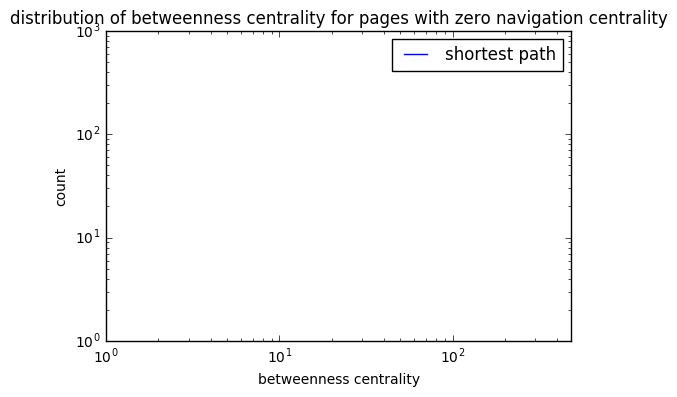

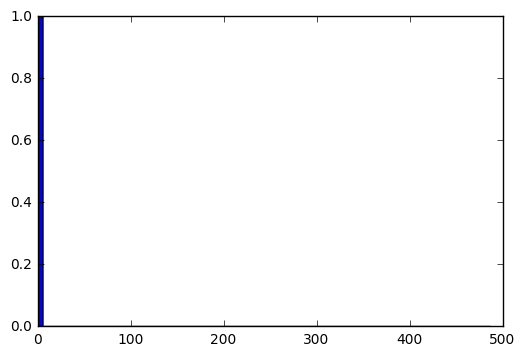

Counter({0.0: 486, 1.6269414124274098e-06: 1, 1.9431790899555965e-06: 1, 7.780112410180876e-06: 1, 1.1809839716049422e-05: 1, 4.800413507416761e-05: 1, 1.156539417048257e-06: 1, 8.466571688478703e-08: 1, 2.855817082575086e-06: 1, 3.897347911513377e-05: 1, 2.790284701879901e-05: 1, 4.0507003980609194e-06: 1, 7.753297162270087e-06: 1, 1.8578712576008245e-06: 1, 7.202540601984964e-08: 1, 0.00013928529295402603: 1, 2.6643119256966146e-08: 1, 7.60885472716601e-06: 1, 1.2529734072492725e-07: 1, 6.689562765430659e-06: 1, 6.665654176598813e-06: 1, 5.695814820085429e-05: 1, 2.2188934509747166e-06: 1, 1.852365786057275e-05: 1, 0.00013552321838453273: 1, 2.2137539672950796e-07: 1, 1.0837440743237574e-05: 1, 2.86431619516465e-07: 1, 4.3633939119892846e-06: 1, 6.165142947717435e-06: 1, 4.737101085957826e-07: 1, 1.8067557415174912e-05: 1, 8.212213957850598e-06: 1, 1.2489975009194603e-05: 1, 3.477839704965002e-06: 1, 8.241157764780967e-06: 1, 5.46979791122553e-06: 1, 2.0805465560668514e-07: 1, 7.7338

In [333]:
bet_cent_0_nav_cent = dict()
for key, cent in nav_cent_dict.iteritems():
    # has zero navigation centrality
    if cent == 0:
        bet_cent_0_nav_cent[key] = b_cent_dict[key]

        
bet = Counter(bet_cent_0_nav_cent.values())
# put data into 10 bins
hist, bin_edges = np.histogram(bet.values(), bins=100)
# plot hist values on loglog scale
line = plt.loglog(bin_edges[:-1], hist, label='shortest path')
plt.xlim(min(bin_edges), max(bin_edges))

plt.legend(handles=line)
plt.title('distribution of betweenness centrality for pages with zero navigation centrality')
plt.ylabel('count')
plt.xlabel('betweenness centrality')
plt.show()

plt.hist(hist, bins=bin_edges)
plt.show()

print bet


> * Now, let's *throw out all pages with zero navigation centrality* and compare navigation- and betweenness centrality for the remaining pages.

>   * What is the correlation between betweenness centrality and navigation centrality?

>   * Comment on the top 5 outliers.

# Bringing the text into the picture

Now that we have an idea about the differences between how humans and computers search in networks, we are going to dig a little deeper using the page content to test a hypothesis to explain why the human navigation paths are longer. The general idea is that humans (who don't know about the global network structure) tend to jump between pages that have related _content_. For this reason we expect that (on average) human navigation paths have more similar content than the shortest paths in the network (which might take 'surprising' shortcuts via relatively unrelated pages). In short.

> **Hypothesis H1**: Human navigation paths have more similar content than network shortest paths.

The way we'll test this hypothesis is to first represent each page as a vector using a bag-of-words approach, then we can calculate a distance between pairs of pages using some vector-space difference, and finally we'll characterize each path by its average pair-wise distance. Below, I've set up that process as an exercise. 

*Exercises*

> First, create a TF-IDF vector for each page. You already know all about TF-IDF from last week's exercise. The main difference is that we now _characterize **each page** by a TF-IDF vector_ and not a group of pages.
> 
> Second, write a function that calculates the distance between a pair of vectors. There are many ways to calculate distances between a pair of vectors (try a Google search for `vector space distance measures` if you want to refresh your knowledge on this topic). You're free to choose what you want, but we recommend the [cosine similarity](https://en.wikipedia.org/wiki/Cosine_similarity).
>
> Now you're ready for the exercises
> 
> * Calculate the average similarity for all human navigation paths (the _source_/_target_ pairs from above). Calculate mean/variance of these average similarities.
> * Calculate the average similarity for all shortest paths between the _source_/_target_ pairs. Calculate mean/variance of these average similarities.
> * Plot the distributions of average similarities for both human- and shortest paths in a single plot. If everything works well, you should see something similar to the following:
![alt text](https://raw.githubusercontent.com/suneman/socialgraphs2016/master/files/path-similarity.png)

> * Finally, for each source/target pair, compare the human-navigation average similarity with the betweenness based average similarity, testing what fraction of the time, the average similarity is lower in the case of human navigation.
> * Comment on your findings. Is **H1** true?